# Covid19 visualizer

In [1]:
%matplotlib notebook

### Colab instructions

- If you are running the notebook in Google Colab, make sure to uncomment the cell bellow and run it, so that it installs the necessary packages and fetches the necessary data. 

In [2]:
# !pip install mplcursors
# %mkdir data
# !gdown https://drive.google.com/uc?id=151jJIOuB_MUiFnJ5VM7Je6IcbFbNH-KL -O data/body_volume_mini.npz
# !gdown https://drive.google.com/uc?id=1wANDPte4_OTIAwq4SREknnCIYTpbgYDm -O data/data_frame_small.json

## Importing of the necessary packages

In [3]:
import os
import sys
import pandas as pd
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import gridspec
import mplcursors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.backend_bases import MouseButton
import seaborn as sns
import ipywidgets as widgets

## Loading the preparing the data

In [4]:
volume = np.load("data/body_volume_mini.npz", allow_pickle=True)['arr_0']
volume = ndimage.zoom(volume, (2, 2, 2, 1), order=0)
dimensions = list(volume.shape[:-1])

In [5]:
dframe_test_sentences = pd.read_json("data/data_frame_small.json")
dframe_test_sentences = dframe_test_sentences[(dframe_test_sentences['title'] != "") & (dframe_test_sentences['abstract'] != "")]

In [6]:
data = dframe_test_sentences.text_mapping.values
data = np.array([np.array(item) for item in data])
data = np.concatenate((data[:, 2][:, None], data[:, 0][:, None], data[:, 1][:, None]), axis=1)
data = np.clip(data, np.array([0.0, 0.0, 0.0]), np.array(dimensions) - 1.0)

## Interactive plots

<IPython.core.display.Javascript object>


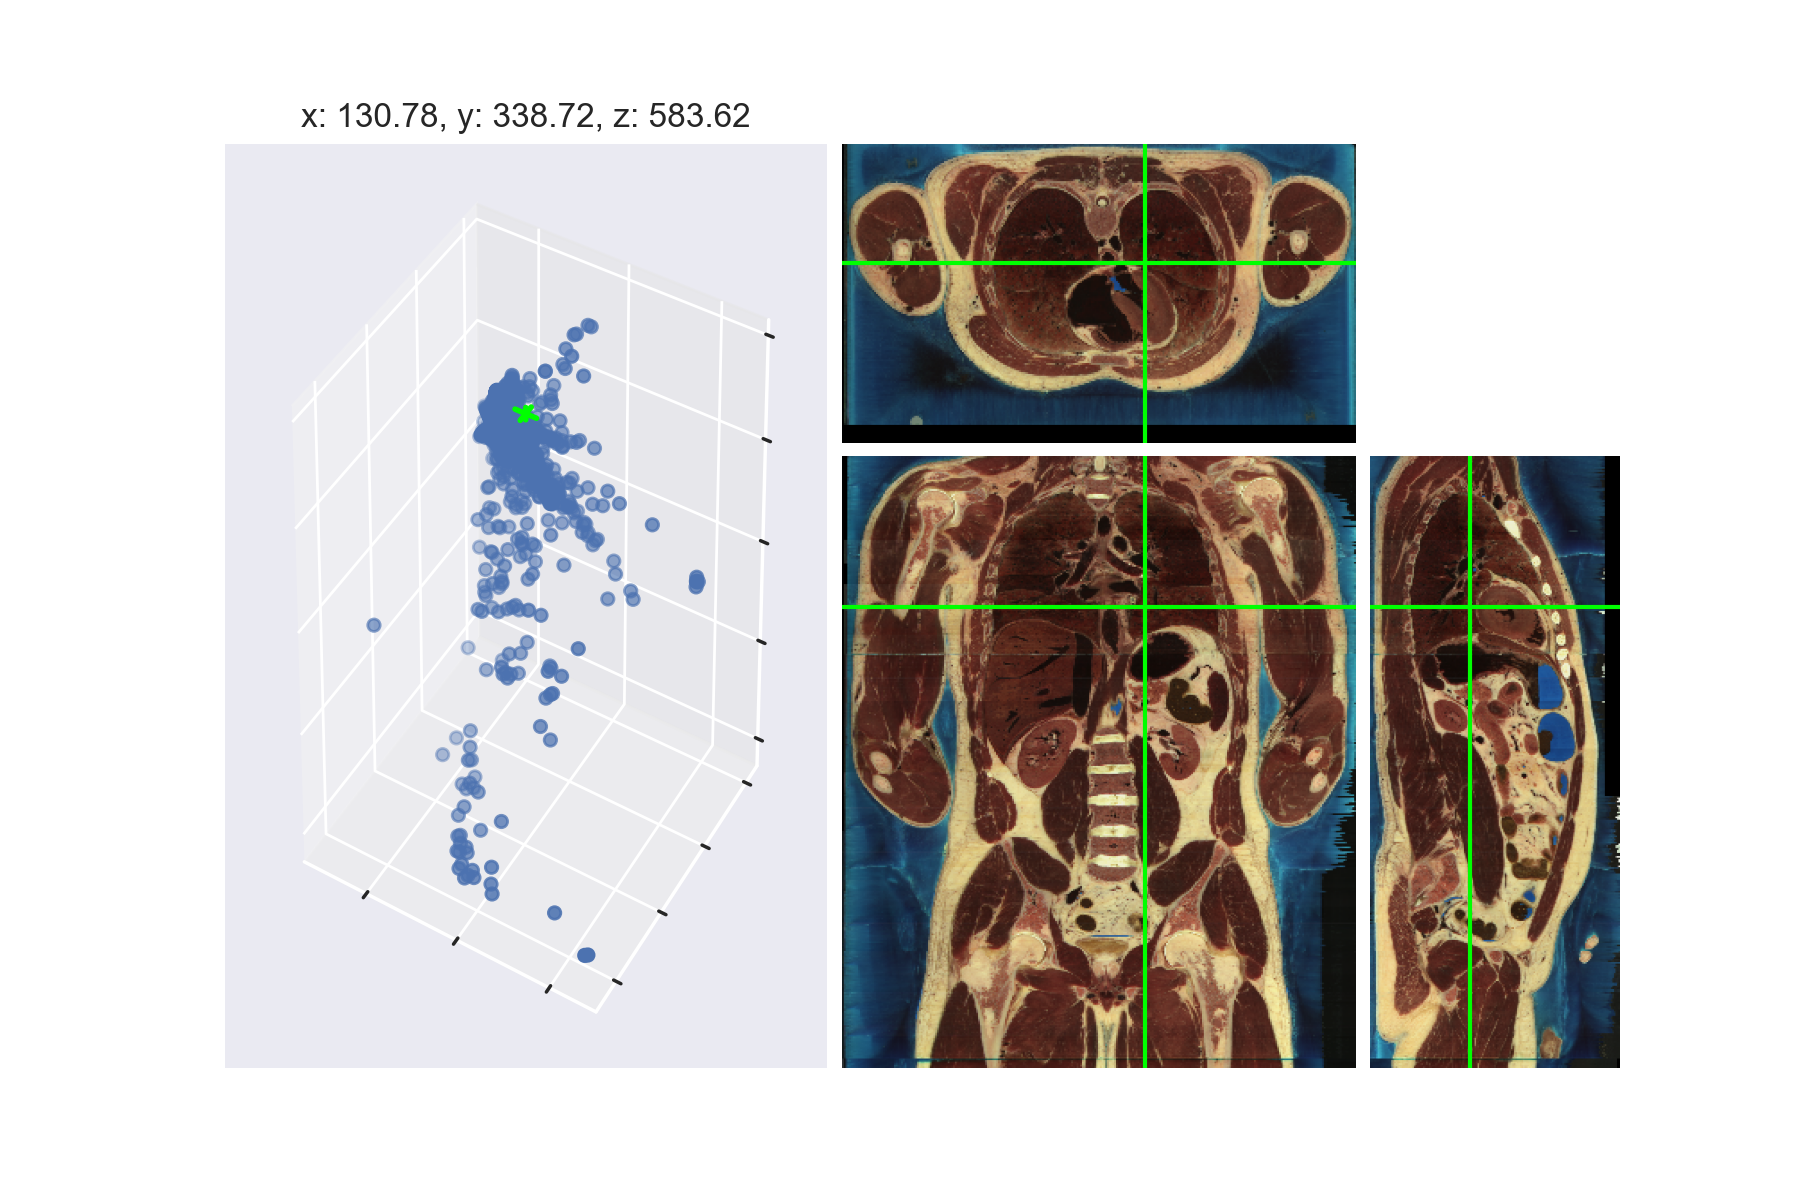

GridBox(children=(HTML(value='', description='Title:'), HTML(value='', description='Author:'), HTML(value='', …

In [7]:
global point

point = [0.0, 0.0, 0.0]

title_box = widgets.HTML(
    value="",
    description="Title:"
)

author_box = widgets.HTML(
    value="",
    description="Author:"
)

abstract_box = widgets.HTML(
    value="",
    description="Abstract:",
)


def create_crosshair(point):
    
    line1, = ax1.plot(point[0] * np.ones(25),
                      point[1] * np.ones(25), 
                      np.arange(point[2]-12, point[2]+13),
                      c='lime',
                      linewidth=2,
                      picker=False)
    line2, = ax1.plot(point[0] * np.ones(25),
                      np.arange(point[1]-12, point[1]+13),
                      point[2] * np.ones(25),
                      c='lime',
                      linewidth=2,
                      picker=False)
    line3, = ax1.plot(np.arange(point[0]-12, point[0]+13),
                      point[1] * np.ones(25),
                      point[2] * np.ones(25), 
                      c='lime',
                      linewidth=2,
                      picker=False)
    return line1, line2, line3



def update_crosshair(point):
    
    line1.set_data(point[0] * np.ones(25), point[1] * np.ones(25))
    line1.set_3d_properties(np.arange(point[2]-12, point[2]+13))
    
    line2.set_data(point[0] * np.ones(25), np.arange(point[1]-12, point[1]+13))
    line2.set_3d_properties(point[2] * np.ones(25))
    
    line3.set_data(np.arange(point[0]-12, point[0]+13), point[1] * np.ones(25))
    line3.set_3d_properties(point[2] * np.ones(25))


def onclick(event):
    '''
    Event handler for button_press_event
    @param event MouseEvent
    '''
    if event.button != MouseButton.LEFT:
        return
    
    if event.inaxes == ax2:   
        
        point[0] = volume.shape[0] - event.ydata
        point[2] = event.xdata
        
        horiz2.set_ydata(event.ydata)
        vert2.set_xdata(event.xdata)
        
        horiz3.set_ydata(event.ydata)
        ax3.index = int(event.xdata)
        ax3.images[0].set_array(volume[:, :, ax3.index])
        
        vert4.set_xdata(event.xdata)
        ax4.index = int(event.ydata)
        ax4.images[0].set_array(volume[ax4.index, :, :])
        
        ax1.set_title(f"x: {point[1]:.2f}, y: {point[2]:.2f}, z: {point[0]:.2f}")
        
    elif event.inaxes == ax3:
        
        point[0] = volume.shape[0] - event.ydata
        point[1] = event.xdata
        
        horiz3.set_ydata(event.ydata)
        vert3.set_xdata(event.xdata)
        
        horiz2.set_ydata(event.ydata)
        ax2.index = int(event.xdata)
        ax2.images[0].set_array(volume[:, ax2.index, :])
        
        horiz4.set_ydata(event.xdata)
        ax4.index = int(event.ydata)
        ax4.images[0].set_array(volume[ax4.index, :, :])
        
        ax1.set_title(f"x: {point[1]:.2f}, y: {point[2]:.2f}, z: {point[0]:.2f}")
        
    elif event.inaxes == ax4:
        
        point[1] = event.ydata
        point[2] = event.xdata
        
        horiz4.set_ydata(event.ydata)
        vert4.set_xdata(event.xdata)
        
        vert2.set_xdata(event.xdata)
        ax2.index = int(event.ydata)
        ax2.images[0].set_array(volume[:, ax2.index, :])
        
        vert3.set_xdata(event.ydata)
        ax3.index = int(event.xdata)
        ax3.images[0].set_array(volume[:, :, ax3.index])
        
        ax1.set_title(f"x: {point[1]:.2f}, y: {point[2]:.2f}, z: {point[0]:.2f}")
        
    else:
        return
    
    update_crosshair([point[1], point[2], point[0]])
    

def onpick(event):
    ind = event.ind[0]
    point = data[ind]
    ax1.set_title(f"x: {point[1]:.2f}, y: {point[2]:.2f}, z: {point[0]:.2f}")

    ax2.index = int(point[1])
    ax2.images[0].set_array(volume[:, ax2.index, :])
    horiz2.set_ydata(volume.shape[0] - point[0])
    vert2.set_xdata(point[2])

    ax3.index = int(point[2])
    ax3.images[0].set_array(volume[:, :, ax3.index])
    horiz3.set_ydata(volume.shape[0] - point[0])
    vert3.set_xdata(point[1])

    ax4.index = int(volume.shape[0] - point[0])
    ax4.index = max(0, min(ax4.index, volume.shape[0] - 1))
    ax4.images[0].set_array(volume[ax4.index, :, :])
    horiz4.set_ydata(point[1])
    vert4.set_xdata(point[2])
    
    update_crosshair([point[1], point[2], point[0]])
    
    title_box.value = dframe_test_sentences.iloc[ind]['title']
    author_box.value = dframe_test_sentences.iloc[ind]['author']
    abstract_box.value = dframe_test_sentences.iloc[ind]['abstract']

sns.set()
fig = plt.figure(figsize = (9, 6))

grid = plt.GridSpec(12, 16, hspace=0.2, wspace=0.2)

ax1 = fig.add_subplot(grid[:, :7], projection='3d')

sc = ax1.scatter(data[:, 1], data[:, 2], data[:, 0], picker=True)
line1, line2, line3 = create_crosshair([volume.shape[1] // 2, volume.shape[2] // 2, volume.shape[0] // 2])


ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

# x, z, y
ax2 = fig.add_subplot(grid[4:, 7:13])
ax2.index = volume.shape[1] // 2
ax2.imshow(volume[:, ax2.index, :], aspect="auto")
horiz2 = ax2.axhline(volume.shape[0] // 2, color='lime')
vert2 = ax2.axvline(volume.shape[2] // 2, color='lime')
ax2.axis('off')

# y, z, x
ax3 = fig.add_subplot(grid[4:, 13:])
ax3.index = volume.shape[2] // 2
ax3.imshow(volume[:, :, ax3.index], aspect="auto")
horiz3 = ax3.axhline(volume.shape[0] // 2, color='lime')
vert3 = ax3.axvline(volume.shape[1] // 2, color='lime')
ax3.axis('off')

ax4 = fig.add_subplot(grid[:4, 7:13])
ax4.index = volume.shape[0] // 2
ax4.imshow(volume[ax4.index, :, :], aspect="auto")
horiz4 = ax4.axhline(volume.shape[1] // 2, color='lime')
vert4 = ax4.axvline(volume.shape[2] // 2, color='lime')
ax4.axis('off')

fig.canvas.mpl_connect('pick_event', onpick)
fig.canvas.mpl_connect('button_press_event', onclick)

cursor = mplcursors.cursor(ax1, highlight=False)   
@cursor.connect("add")
def _(sel):
    sel.annotation.set(text="", bbox=None)
    sel.annotation.arrow_patch.set(alpha=0.0)

    
widget_box = widgets.GridBox(children=[title_box, author_box, abstract_box],
        layout=widgets.Layout(
            width='100%',
            grid_template_rows='10% 10% 60%',
            grid_template_columns='100%',
            grid_template_areas='''
            "title_box"
            "author_box"
            "abstract_box"
            ''')
       )

widget_box